In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
run utils.py

In [1]:
## import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalanceCascade 

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from time import time

In [2]:
def plot_confusion_matrix(prediction, y_test):
    plt.figure(figsize=(15, 6))
    c_matrix = confusion_matrix(y_test, prediction)
    c_matrix_ = np.round(100 * c_matrix / c_matrix.sum(axis=1).reshape(-1, 1))
    plt.subplot(121)
    sns.heatmap(c_matrix, annot=True, fmt="d");
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.subplot(122)
    sns.heatmap(np.asarray(c_matrix_, dtype=int), annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_roc_auc_score(prediction, y_test):
    value = np.round(roc_auc_score(y_test, prediction[:,1]),4)
    print('ROC AUC score:',  value)
    
    return value

def get_pr_auc_score(prediction, y_test):
    value = np.round(average_precision_score(y_test, prediction[:, 1]),4)
    print('PR AUC score:',  value)
    
    return value
    
def plot_curves(prediction, y_test):
    tpr, fpr, _ = roc_curve(y_test, prediction[:,1])
    roc_auc = roc_auc_score(y_test, prediction[:,1])
    
    precision, recall, _ = precision_recall_curve(y_test, prediction[:,1])
    average_precision = average_precision_score(y_test, prediction[:,1])

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.step(tpr, fpr, color='b', alpha=0.2, where='post')
    plt.fill_between(tpr, fpr, step='post', alpha=0.2, color='b')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class ROC curve: ROC AUC={0:0.2f}'.format(roc_auc))

    plt.subplot(122)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
def get_threshold_by_f1(prediction_proba, y_test, plot=False):
    thresholds = np.linspace(prediction_proba[:, 1].min(), prediction_proba[:, 1].max(), 300)
    curve = []
    for val in thresholds:
       
        prediction = np.asarray((prediction_proba[:, 1] >= val), int)
        curve.append(f1_score(prediction, y_test))

    argmax = np.argmax(curve)

    if plot == True:
        plt.figure(figsize=(14, 4))
        plt.plot(thresholds, curve)
        plt.title('F1 curve', fontsize=16)
        plt.plot([thresholds[argmax]] * 2, [np.min(curve), np.max(curve)])
    
    return thresholds[argmax]

def plot_probas(prediction_proba, y_test):
    plt.figure(figsize=(14, 4))
    probas = prediction_proba[:, 1]
    ax = sns.distplot(probas)
    proba_mean = probas.mean()
    proba_f1_best = get_threshold_by_f1(prediction_proba, y_test)
    plt.plot([proba_mean] * 2, ax.get_ylim(), label='Mean of probabilites')
    plt.plot([proba_f1_best] * 2, ax.get_ylim(), label='Best threshold by f1 score')
    plt.legend(fontsize=16)

In [3]:
data = pd.read_pickle('../../Datasets/TransformedFullData.pkl')
#data = pd.read_csv('TransformedData.csv')
#data.fillna(0, inplace=True)

In [4]:
## train test split of data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['ID', 'target'], axis=1), data.target, random_state=0)

In [5]:
len(X_train), len(X_test) / len(data)

(285759, 0.2500019684367725)

## 0 Baseline

/home/rasul/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ROC AUC score: 0.9061
PR AUC score: 0.1704
CPU times: user 1min 34s, sys: 13.3 s, total: 1min 47s
Wall time: 39 s


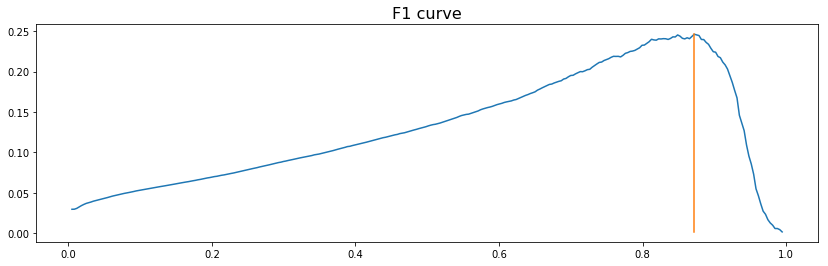

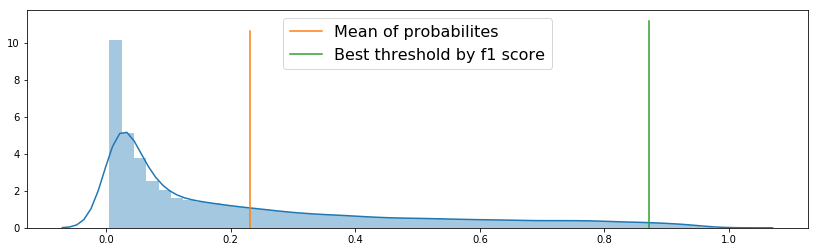

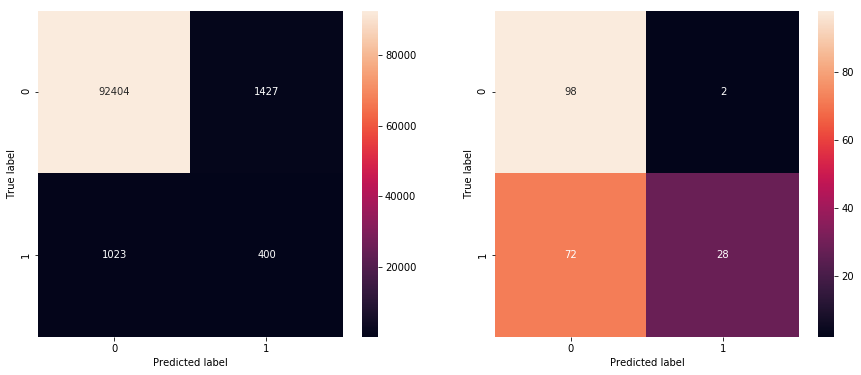

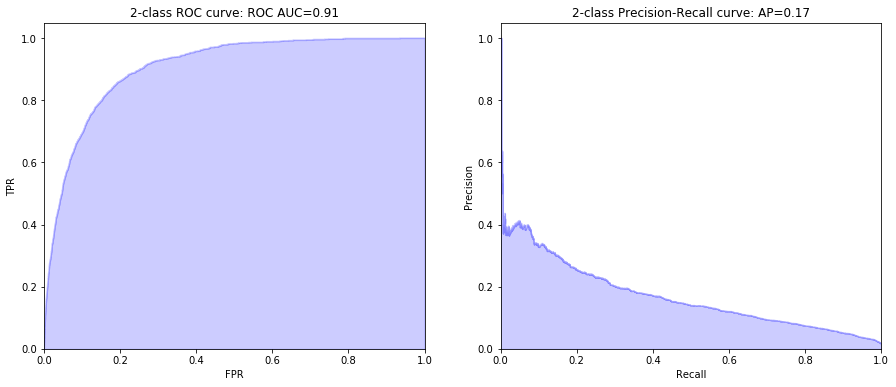

In [6]:
%%time 
model = LGBMClassifier(class_weight={0: y_train.mean(), 1: 1 - y_train.mean()})
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

/home/rasul/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ROC AUC score: 0.8809
PR AUC score: 0.161
CPU times: user 21min 45s, sys: 27.2 s, total: 22min 12s
Wall time: 1min 40s


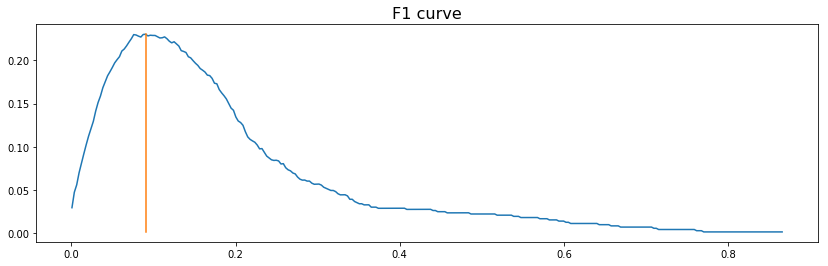

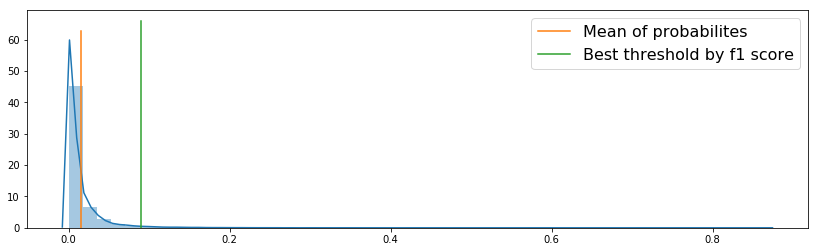

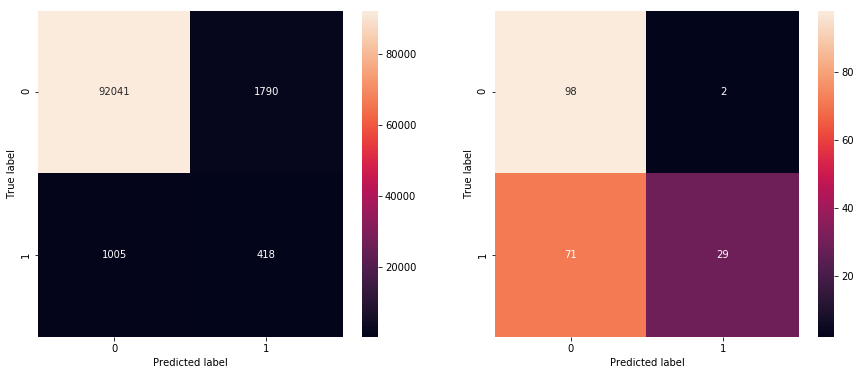

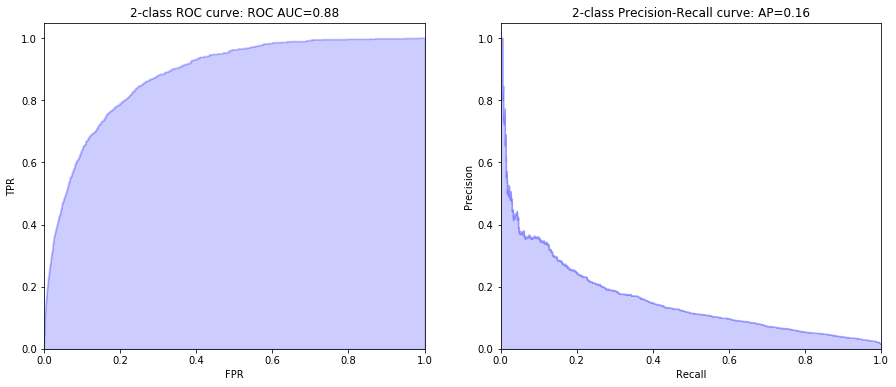

In [7]:
%%time 
model = XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

## Imbalanced Learning 

### 1 Over-sampling
#### 1.1 Naive random over-sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
%%time 
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 1.2  SMOTE: Synthetic Minority Oversampling Technique

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
%%time 
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 1.3 ADASYN: Adaptive Synthetic sampling method

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
%%time 
X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 2 Under-sampling
#### 2.1  Controlled under-sampling techniques

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
%%time
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 2.2 Cleaning under-sampling techniques

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

In [ ]:
%%time
X_resampled, y_resampled = EditedNearestNeighbours(random_state=0).fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [ ]:
%%time
X_resampled, y_resampled = RepeatedEditedNearestNeighbours(random_state=0).fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
from imblearn.under_sampling import AllKNN

In [ ]:
%%time
X_resampled, y_resampled = AllKNN(random_state=0).fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 2.3  Instance hardness threshold

In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [ ]:
%%time
iht = InstanceHardnessThreshold(random_state=0)
X_resampled, y_resampled = iht.fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 3 Combination of over- and under-sampling

In [ ]:
from imblearn.combine import SMOTEENN

In [ ]:
%%time
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X_train, y_train)

In [ ]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = XGBClassifier(n_jobs=-1)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 
model = CatBoostClassifier(verbose=False)
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 4 Ensemble of samplers

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier

In [ ]:
%%time 

model = BalancedBaggingClassifier(base_estimator=LGBMClassifier(),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = BalancedBaggingClassifier(base_estimator=XGBClassifier(n_jobs=-1),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [ ]:
%%time 

model = BalancedBaggingClassifier(base_estimator=CatBoostClassifier(verbose=False),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

## Balancing data

In [ ]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip(np.arange(15, 200, 5),'bgrcmykw'):
    lr_model = LGBMClassifier(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_test)[:,1]
    print('w = ', w) 
    get_roc_auc_score(lr_model.predict_proba(X_test), y_test)
    get_pr_auc_score (lr_model.predict_proba(X_test), y_test)
    
    p,r,_ = precision_recall_curve(y_test, pred_prob)
    tpr,fpr,_ = roc_curve(y_test, pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()